# Automated Software Improvement: A Machine Learning Solution
## First Iteration - Prop Line Compiled
### 2727141 Luke Skinner
### Supervisor: Dr Sandy Brownlee

## Overview

These notebooks contain all the work performed on the first iteration of the Machine Learning model(s) to help guide automated improvement of Software. The dataset provided for this iteration is "merged_stats_sb_17112020_amended.csv" (this was amended to fix an issue with a column which would have skewed a lot of the data) which is an aggregate of experimental results of edits performed on open source projects. This will include the first cycle of building an effective model. However, it is expected that this first iteration will not be sufficient for accurate results therefore the main goal of this iteration is to discover features which are important to both compiling and passing tests. These edits should be successful and when applied through Gin they should result in some reduction of runtime. Several Models will be made to target the two different styles of edits (line & statement). 

#### Imports

In [1]:
import seaborn as sns 
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib as plt
from scipy.stats import loguniform

#### Utility Functions

In [4]:
def cacl_adj_r2(r2, n, k):
    """
    Calculates the adjusted r2 score based on the following formula:
    Adjusted r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1). This is used to
    complement the original r2 score to give a better understanding of
    how the model explains variance of the predictor variables

    Parameters:
        r2 (float): The original r2 score (from sklearn)
        n (int): The number of observations
        k (int): The number of predictor variables

    Returns:
        adj_r2 (float): The adjusted r2 score 
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)
    

#### Load Dataset

In [5]:
df = pd.read_csv('data/merged_stats_sb_17112020_amended.csv')

## Proposed Model 3 - Proportion Line Compiled
## 1. Data Visualisation

In [5]:
df.corrwith(df['PropLineCompiled']).drop('PropLineCompiled')

MethodIndex                   0.113541
numLines                      0.196381
numStatements                 0.208033
EditDensity                  -0.065704
AveUseDefDist                 0.184090
NotDeclared                  -0.006182
AveUseDefDist/MethodLength    0.075969
MedDefUseDist                 0.257963
MedUseDefDist/MethodLength    0.055868
CountLine                    -0.002581
CompiledLine                  0.110331
PassedLine                    0.097894
CountStat                    -0.002581
CompiledStat                  0.042993
PassedStat                    0.033361
PropLinePassed                0.816889
PropStatCompiled              0.535581
PropStatPassed                0.358018
cyclomatic                    0.152536
ncss                          0.216290
npath                         0.066076
cyc/length                   -0.109649
ncss/length                   0.278184
npath/length                  0.022624
InstCoverage-missed           0.086662
InstCoverage-covered     

<AxesSubplot:xlabel='PropLineCompiled', ylabel='PropLinePassed'>

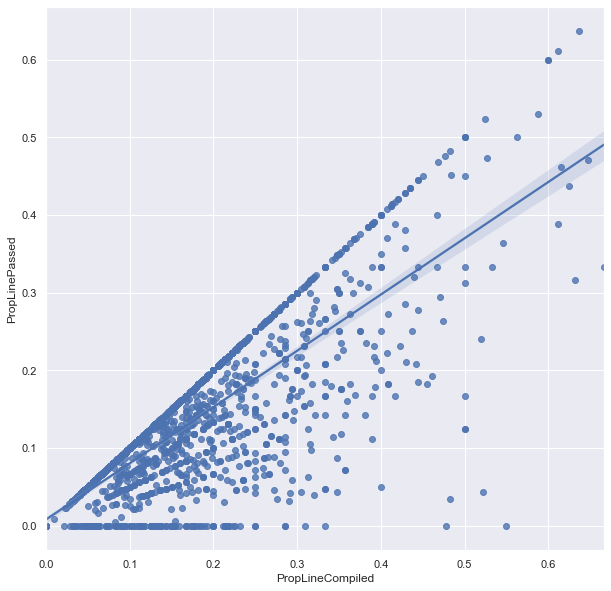

In [6]:
# Lets plot that using a regplot from seaborn
x_axis = df['PropLineCompiled']

y_axis = df['PropLineCompiled']

sns.set(rc = {'figure.figsize' : (10, 10)})

sns.regplot(x=x_axis, y=y_axis)

## 2. Data Preparation

In [6]:
# Lets remove the non numerical fields as they are not useful for the model
df_new = df.drop(['CompositeKey', 'Project', 'MethodName', 'MethodIndex'], axis=1)

df_new.info() 

# We will filter out all rows which have a numLines < 10, we also want to only look at rows with sensible npath values
df_new = df_new[(df_new.numLines > 10) & (df.npath > -1) ]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numLines                    2157 non-null   int64  
 1   numStatements               2157 non-null   int64  
 2   EditDensity                 2157 non-null   float64
 3   AveUseDefDist               2157 non-null   float64
 4   NotDeclared                 2157 non-null   int64  
 5   AveUseDefDist/MethodLength  2157 non-null   float64
 6   MedDefUseDist               2157 non-null   float64
 7   MedUseDefDist/MethodLength  2157 non-null   float64
 8   CountLine                   2157 non-null   int64  
 9   CompiledLine                2157 non-null   int64  
 10  PassedLine                  2157 non-null   int64  
 11  CountStat                   2157 non-null   int64  
 12  CompiledStat                2157 non-null   int64  
 13  PassedStat                  2157 

## 3. Beginning Train/Test split

##### We now want to identify the features which are most important, we will start by looking at all the other fields with respect to the target. First we will split the data 70%/30%.

In [7]:
X = df_new.drop(['PropLineCompiled'], axis=1)

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(647, 26)
(278, 26)
(647,)
(278,)


## 4. Feature Importances at a glance

##### To get the feature importances, we will first start by fitting an overall RandomForest model on the data and seeing what it produces as feature importances. This will not be the final model.

PropLinePassed                0.554686
CompiledLine                  0.246793
CountStat                     0.037866
PropStatCompiled              0.033423
CountLine                     0.032753
EditDensity                   0.013077
ncss/length                   0.012924
PassedStat                    0.008314
MedUseDefDist/MethodLength    0.007371
MedDefUseDist                 0.006983
dtype: float64


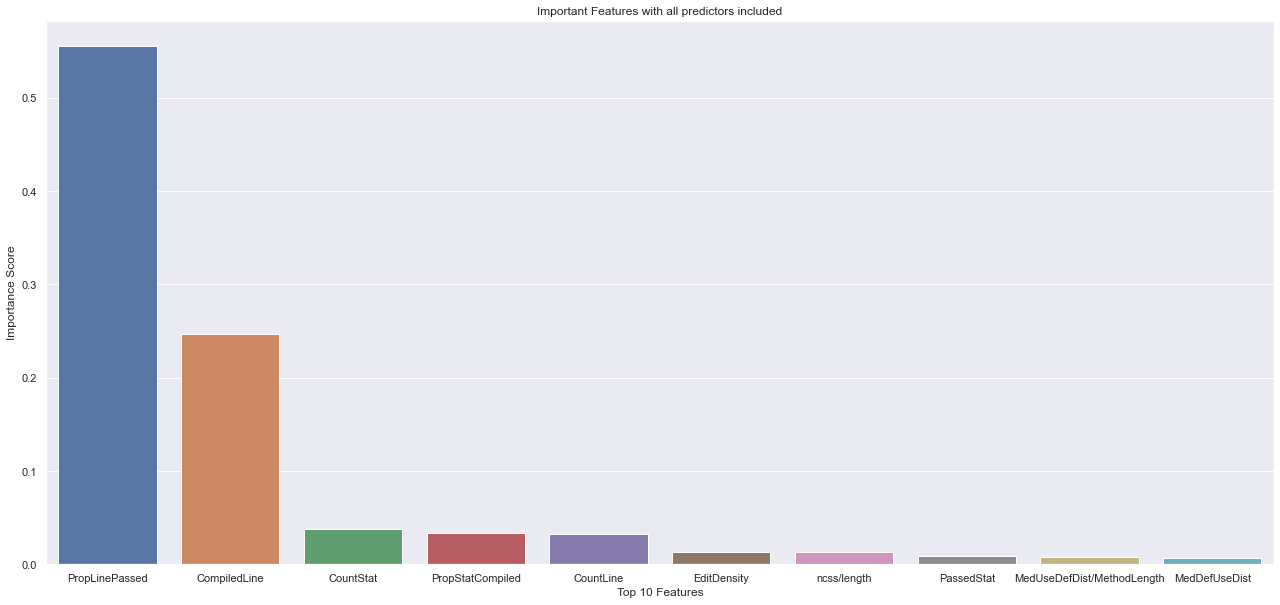

In [15]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with all predictors included', xticklabels=top_10.index)

print(top_10)

In [16]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.89747
Adj. R2: 0.89440
RMSE: 0.00120
MAE: 0.02093


## 5. Feature Selection

##### After getting the initial result with all features included, let's see what happens when we drop certain features, starting with PassedLine.

In [17]:
# Building a model, dropping PassedLine
X = df_new.drop(['PropLineCompiled', 'CompiledLine'], axis=1)

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(628, 25)
(270, 25)
(628,)
(270,)


PropLinePassed                0.671323
PropStatCompiled              0.066878
ncss/length                   0.030435
PropStatPassed                0.029116
InstCoverage-covered          0.020428
PassedStat                    0.018138
MedDefUseDist                 0.016319
EditDensity                   0.015205
MedUseDefDist/MethodLength    0.014661
cyc/length                    0.013244
dtype: float64


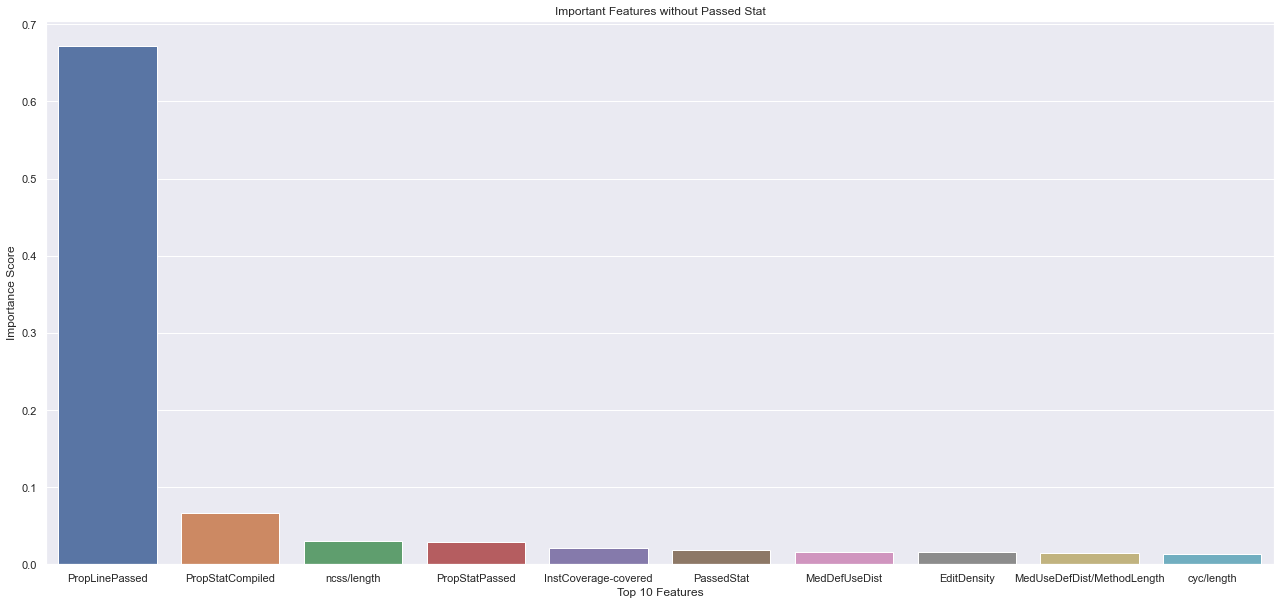

In [18]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features without Passed Stat', xticklabels=top_10.index)

print(top_10)

In [19]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.62324
Adj. R2: 0.61244
RMSE: 0.00440
MAE: 0.04719


In [20]:
# Building a model with just the metrics
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)


(628, 8)
(270, 8)
(628,)
(270,)


ncss/length      0.222420
AveUseDefDist    0.176349
MedDefUseDist    0.158527
cyc/length       0.132039
npath/length     0.100975
ncss             0.093746
cyclomatic       0.063499
npath            0.052445
dtype: float64


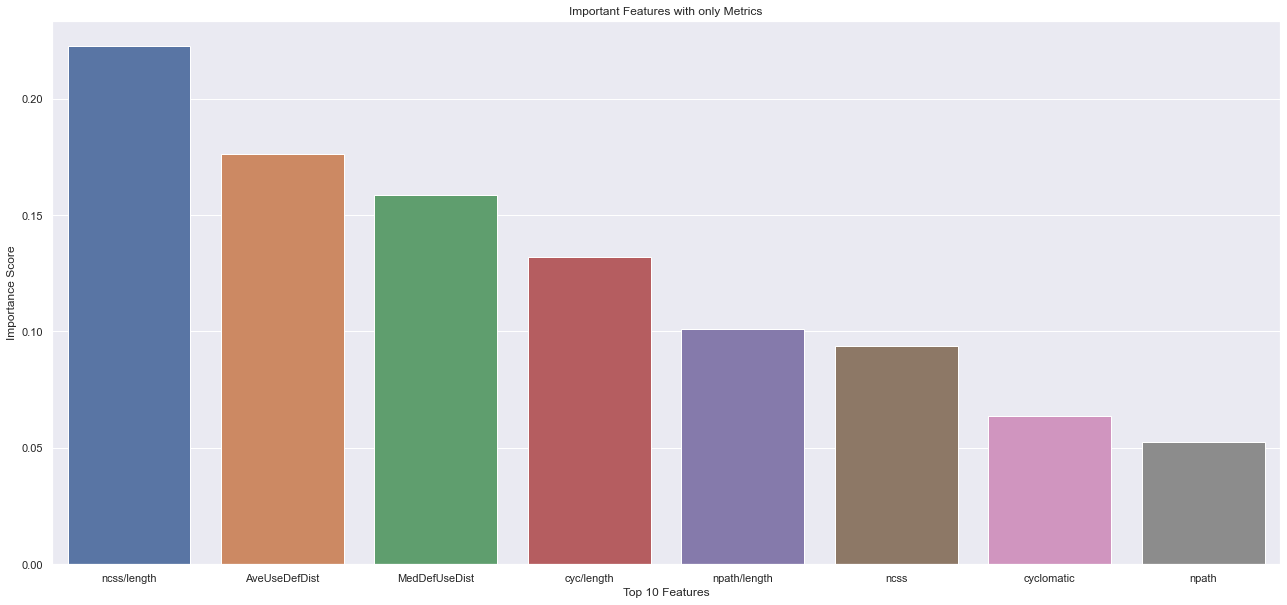

In [21]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with only Metrics', xticklabels=top_10.index)

print(top_10)

In [22]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.13537
Adj. R2: 0.12759
RMSE: 0.01010
MAE: 0.07716


In [25]:
# Building a model where the related compile features are removed
X = df_new.drop(['PropLineCompiled', 'PropStatPassed', 'PassedStat', 'PropLineCompiled'], axis=1)

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(628, 23)
(270, 23)
(628,)
(270,)


CompiledLine                  0.608645
CountLine                     0.140640
CountStat                     0.138814
PropStatCompiled              0.053840
EditDensity                   0.011032
ncss/length                   0.006813
PassedLine                    0.005043
cyc/length                    0.004641
MedUseDefDist/MethodLength    0.003713
npath/length                  0.003665
dtype: float64


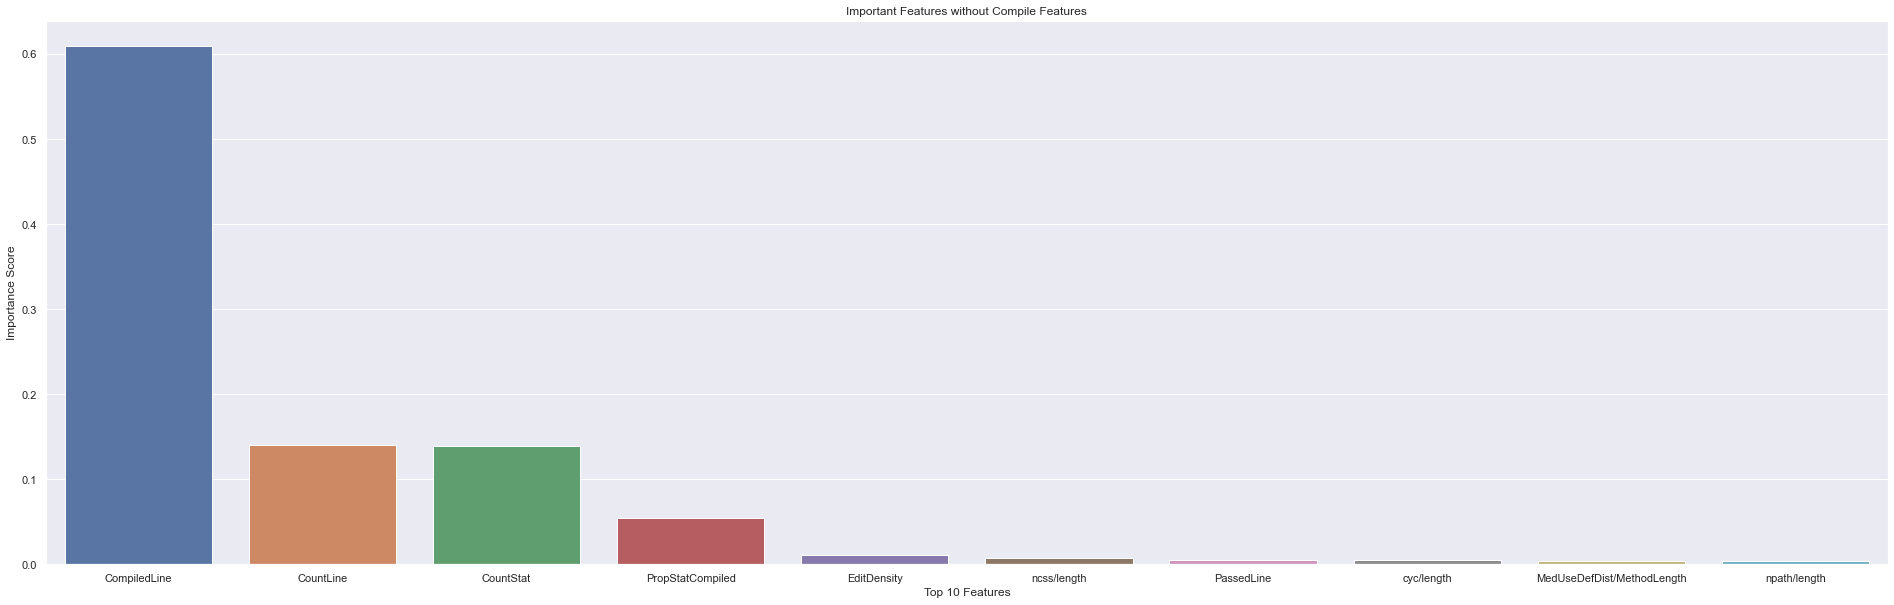

In [26]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (33, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features without Compile Features', xticklabels=top_10.index)

print(top_10)


In [27]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.94035
Adj. R2: 0.93878
RMSE: 0.00070
MAE: 0.01379


## 6. Model Evaluation

### 6.1.1 Ridge Regression without Tuning

In [11]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge() 

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")


R2 Score: 0.06803
Adj. R2: 0.05886
RMSE: 0.01171
MAE: 0.08234


### 6.1.2 Ridge Regression with Tuning

In [ ]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']

space['alpha'] = loguniform(1e-5, 100)

space['fit_intercept'] = [True, False]

space['normalize'] = [True, False]

# Define search
random_search = RandomizedSearchCV(ridge, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)



In [12]:
ridge = Ridge(solver='sag', fit_intercept=True, normalize=True, alpha=0.09562046996428594)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.08344
Adj. R2: 0.07443
RMSE: 0.01152
MAE: 0.08161


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


### 6.2.1 KNN without Tuning

In [13]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.09655
Adj. R2: -0.10734
RMSE: 0.01378
MAE: 0.08897


### 6.2.2 KNN with Tuning

In [54]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()

space['algorithm'] = ['ball_tree', 'kd_tree', 'brute']

space['n_neighbors'] = [2, 3, 5, 10, 12, 15, 20, 25, 30, 40]

space['weights'] = ['uniform', 'distance']

space['leaf_size'] = [10, 30, 60, 80, 90, 120, 140]

space['p'] = [1, 2, 3]

# Define search
random_search = RandomizedSearchCV(knnreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)

Random Search Best Score: -0.08446522469727881
Random Search Best Hyperparameters: {'weights': 'distance', 'p': 3, 'n_neighbors': 40, 'leaf_size': 60, 'algorithm': 'kd_tree'}


In [15]:
knnreg = KNeighborsRegressor(n_neighbors=40, weights='distance', p=3, leaf_size=60, algorithm='kd_tree')

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
    
adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.04047
Adj. R2: 0.03103
RMSE: 0.01206
MAE: 0.08318


### 6.3.1 RandomForest without Tuning

In [16]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")
print(rforestreg.get_params())

R2 Score: 0.08512
Adj. R2: 0.07612
RMSE: 0.01150
MAE: 0.08176
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### 6.3.2 RandomForest with Tuning

In [57]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()

space['n_estimators'] = [100, 250, 300, 350, 400, 450, 500]

space['bootstrap'] = [True, False]

space['warm_start'] = [True, False]

space['ccp_alpha'] = loguniform(1e-5, 100)

# Define search
random_search = RandomizedSearchCV(rforestreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


Random Search Best Score: -0.0820511820164176
Random Search Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.00011536500712258745, 'n_estimators': 100, 'warm_start': True}


In [17]:
rforestreg = RandomForestRegressor(n_estimators = 100, warm_start=True, bootstrap=True, ccp_alpha=0.00011536500712258745)

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.08840
Adj. R2: 0.07944
RMSE: 0.01146
MAE: 0.08167


### 6.4.1 MLPRegressor without Tuning

In [65]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -10.88935
Adj. R2: -11.00985
RMSE: 0.13891
MAE: 0.14383


### 6.4.2 MLPRegressor with Tuning

In [ ]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropLineCompiled']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['hidden_layer_sizes'] = [(50,50,50), (50,100,50), (100,1), (100, 50, 1)]

space['activation'] = ['relu', 'tanh', 'logistic']

space['alpha'] = loguniform(1e-5, 100)

space['learning_rate'] = ['constant', 'adaptive']

space['solver'] = ['adam', 'lbfgs']

# Define search
random_search = RandomizedSearchCV(mlpreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)
                     
print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


In [48]:
mlpreg = MLPRegressor(activation='tanh', alpha=2.4192008174146014, hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive', solver='adam')

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.00521
Adj. R2: -0.01509
RMSE: 0.01074
MAE: 0.07616
